In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


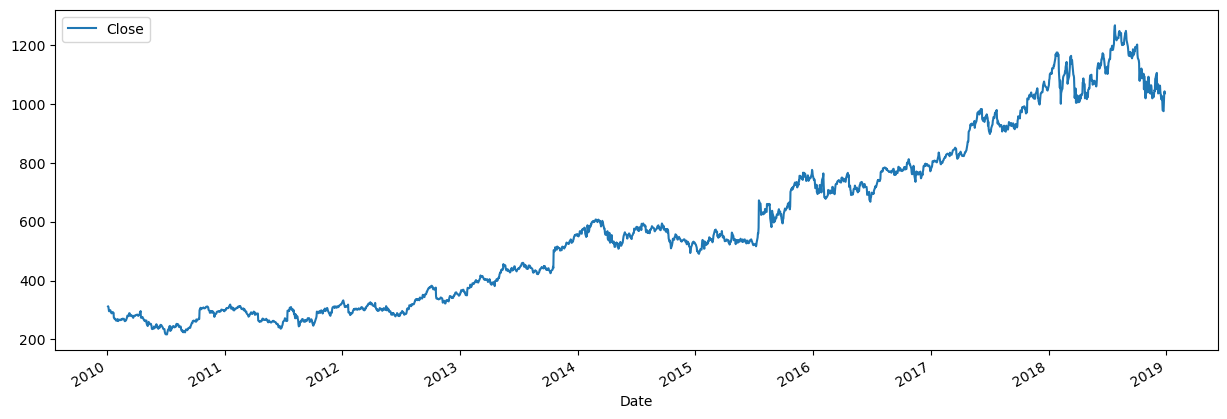

In [3]:
goog = df[df['Name'] == 'GOOG'][['Close']].copy()
goog.plot(figsize=(15, 5));

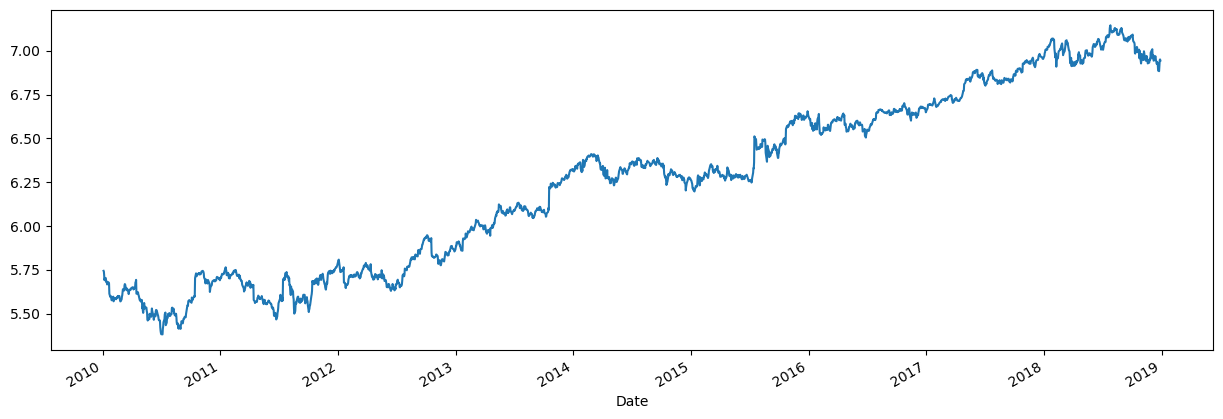

In [6]:
goog['LogClose'] = np.log(goog['Close'])
goog['LogClose'].plot(figsize=(15, 5));

In [7]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]
# boolean series to index df rows
train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw = ExponentialSmoothing(
    train['LogClose'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal=None)
res_hw = hw.fit()

/Users/stefanduprey/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
goog.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues
goog.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest).to_numpy()

/Users/stefanduprey/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/stefanduprey/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


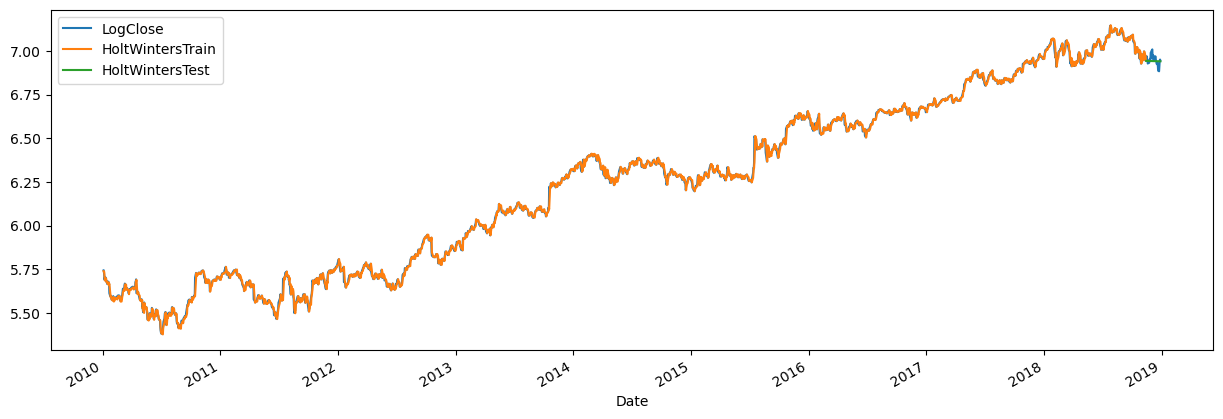

In [10]:
goog[['LogClose', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(15, 5));

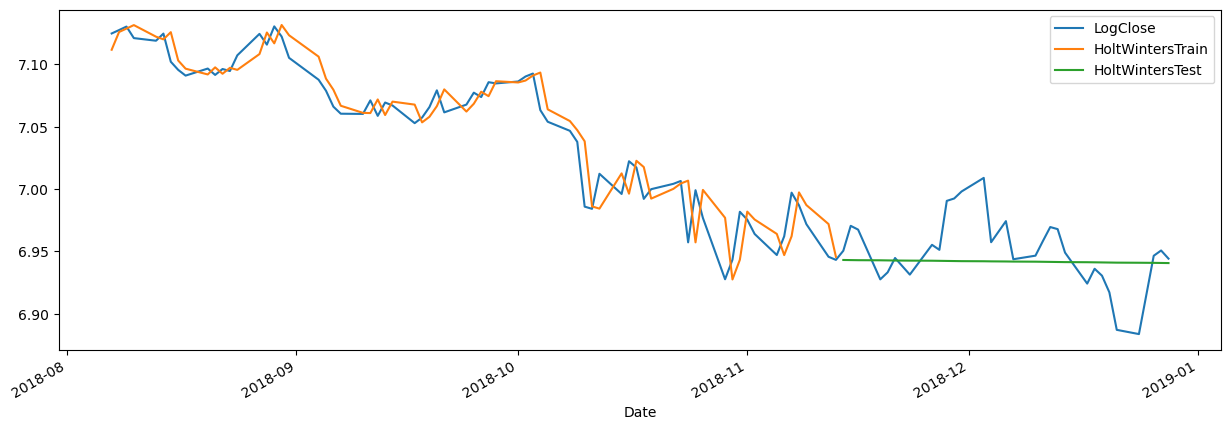

In [11]:
cols = ['LogClose', 'HoltWintersTrain', 'HoltWintersTest']
goog.iloc[-100:][cols].plot(figsize=(15, 5));

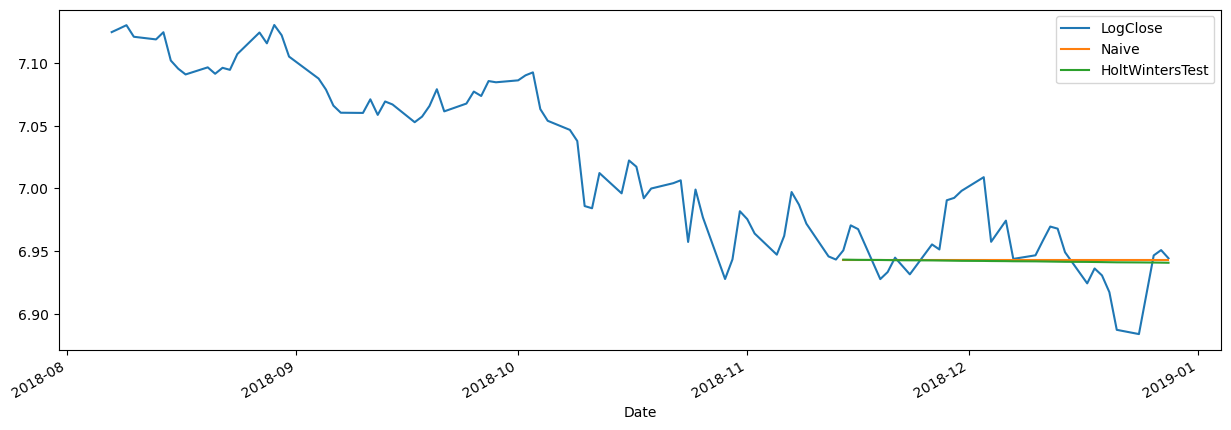

In [12]:
goog.loc[test_idx, 'Naive'] = train.iloc[-1]['LogClose']
goog.iloc[-100:][['LogClose', 'Naive', 'HoltWintersTest']].plot(figsize=(15, 5));

In [11]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'Naive'])

-0.06454209862026317

In [12]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'HoltWintersTest'])

-0.15876524524474056